In [1]:
import os
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
from utils import data_handler
from utils.models import LSTM



import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go



%load_ext tensorboard
!rm -rf ../workfiles/logs/

'rm' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [2]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

sgdc_params = {
            #'penalty':["elasticnet", "l1", "l2"],
            'penalty':["l1"],
            #'l1_ratio':np.linspace(0.1, 1, 5),
            'alpha':np.linspace(0.1, 0.5, 5),
        }


absolute_path = "c:/thesis/data/quant"
metadata_path = "c:/thesis/METADATA_200123.xlsx"


x_train, filenames, n_genes = data_handler.generate_dataset(path = absolute_path,
                                                            metadata_path = metadata_path,
                                                            feature_selection_threshold = 25, 
                                                   #feature_selection_proceedure = "LASSO", 
                                                   retain_phases="Both", 
                                                   #retain_phases=None, 
                                                   return_id = True,
                                                   sgdc_params = sgdc_params,
                                                   #subsample = 100,
                                                   #class_balancing = "match_smaller_sample")
                                                   class_balancing = "balanced",
                                                   as_time_series = True,
                                                   normalization = True,
                                                   transpose=True,
                                                   batch_size=32)


Retaining patients that are included in phases 1 & 2
retaining all patient who have passed all visits...
loading samples...
loaded 1455 samples
selecting genes based on median absolute deviation threshold:  25 ...
number of genes selected :  1014
normalizing data...
normalization done
number of seq in the dataset : 1455
converting samples to time series
number of actual individual to be studied : 291
using transposed data...


In [3]:
importlib.reload(LSTM) # to allow modification of the script without restarting the whole session

latent_dim = 32
sequence_length = 5

t_shape = (sequence_length, n_genes)

# SINCE WE USE TRANSPOSE :
t_shape = (n_genes, sequence_length)


autoencoder = LSTM.generate_model(t_shape, latent_dim, True)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [4]:
checkpoint_filepath = '../workfiles/simple_ae/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=50, min_lr=0.000001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=75)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, 
      reduce_lr, 
      early_stopping_callback, 
      tensorboard_callback]

In [5]:
#%tensorboard --logdir ../workfiles/logs/fit

In [6]:
autoencoder.build( (None, n_genes, sequence_length))

In [7]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1014, 1024)       2121728   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1014, 512)        2623488   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               139520    
 nal)                                                            
                                                                 
Total params: 4,884,736
Trainable params: 4,884,736
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)           

4k ish

12K for 512 + 256


In [19]:
hist = autoencoder.fit(x_train, epochs=5000, callbacks=cb)

Epoch 1/5000


10/10 [==============================] - 13s 1s/step - loss: 6.0055e-04 - lr: 1.0000e-06
Epoch 2/5000
10/10 [==============================] - 12s 1s/step - loss: 6.0042e-04 - lr: 1.0000e-06
Epoch 3/5000
10/10 [==============================] - 12s 1s/step - loss: 6.0050e-04 - lr: 1.0000e-06
Epoch 4/5000
10/10 [==============================] - 12s 1s/step - loss: 6.0089e-04 - lr: 1.0000e-06
Epoch 5/5000
10/10 [==============================] - 12s 1s/step - loss: 6.0192e-04 - lr: 1.0000e-06
Epoch 6/5000
10/10 [==============================] - 12s 1s/step - loss: 6.0245e-04 - lr: 1.0000e-06
Epoch 7/5000
10/10 [==============================] - 12s 1s/step - loss: 6.0132e-04 - lr: 1.0000e-06
Epoch 8/5000
10/10 [==============================] - 12s 1s/step - loss: 6.0061e-04 - lr: 1.0000e-06
Epoch 9/5000
10/10 [==============================] - 12s 1s/step - loss: 6.0033e-04 - lr: 1.0000e-06
Epoch 10/5000
10/10 [==============================] - 12s 1s/step - loss: 6.0025e-04 - lr: 1.0

10/10 [==============================] - 10s 960ms/step - loss: 8.2001e-04 - lr: 1.0000e-05


In [46]:
autoencoder.load_weights(checkpoint_filepath)


[0.022757165133953094, 0.002031101146712899, 0.0026125770527869463, 0.0022049492690712214, 0.0020208570640534163, 0.0014157891273498535, 0.0012317515211179852, 0.0013674062211066484, 0.0012666910188272595, 0.0011566898319870234, 0.0010601213434711099, 0.0010136483469977975, 0.0010169657180085778, 0.0010383209446445107, 0.000986727885901928, 0.001074878848157823, 0.0011111823841929436, 0.0010597739601507783, 0.0010727496119216084, 0.0010680969571694732, 0.0009578801691532135, 0.0009727359283715487, 0.0009603875805623829, 0.0009462460875511169, 0.0009575457079336047, 0.0010552552994340658, 0.0010930466232821345, 0.0010596935171633959, 0.0010116836056113243, 0.0009490307420492172, 0.0009688515565358102, 0.0009469470824114978, 0.0009664218523539603, 0.0009437404223717749, 0.0009052685345523059, 0.0009116684086620808, 0.0009019452845677733, 0.000915138574782759, 0.0009309134329669178, 0.0008915036451071501, 0.0009014379465952516, 0.0009116786532104015, 0.0009063013712875545, 0.0009023636812

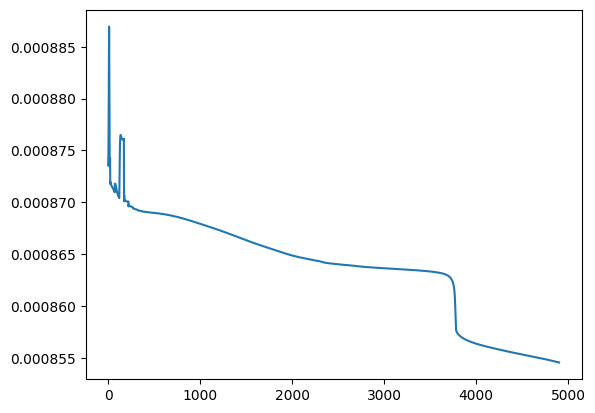

In [10]:
plt.plot(hist.history['loss'][100:])
print(hist.history['loss'])

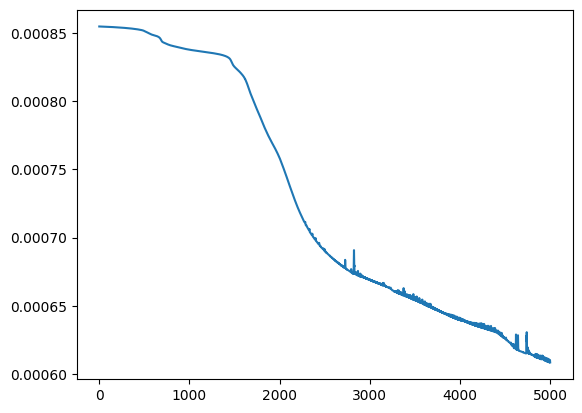

In [12]:
plt.plot(hist.history['loss'])


### some diagnosis

In [20]:
e = iter(x_train).next()
z = autoencoder.encoder(e)
decoded = autoencoder.decoder(z)

In [21]:
e_ = e[0]  
z_ = z[0].reshape(1, -1) 
decoded_ = decoded[0]  



# Create subplot grid with vertical stacking
fig = sp.make_subplots(rows=3, cols=1, shared_xaxes=False, vertical_spacing=0.1)

# Add the original image as a heatmap-like plot
heatmap_trace1 = go.Heatmap(z=e_, colorscale='viridis')
fig.add_trace(heatmap_trace1, row=1, col=1)

# Add the latent representation as a heatmap-like plot
tensor_reshaped = z.reshape(1, -1)
heatmap_trace2 = go.Heatmap(z=z_, colorscale='viridis')
fig.add_trace(heatmap_trace2, row=2, col=1)

# Add the decoded image as a heatmap-like plot
heatmap_trace3 = go.Heatmap(z=decoded_, colorscale='viridis')
fig.add_trace(heatmap_trace3, row=3, col=1)

# Update layout
fig.update_layout(title='Stacked Graph of Image and Latent Space', showlegend=False)

# Update x-axis labels
#fig.update_xaxes(title_text='genes (normalized)', row=1, col=1)
#fig.update_xaxes(title_text='latent representation', row=2, col=1)
#fig.update_xaxes(title_text='genes (normalized)', row=3, col=1)

# Update y-axis labels
#fig.update_yaxes(title_text='timestamps', row=1, col=1)
#fig.update_yaxes(title_text='latent representation', row=2, col=1)
#fig.update_yaxes(title_text='timestamps', row=3, col=1)

fig.show()

In [22]:
autoencoder.encoder.save('../workfiles/T_LSTM')


INFO:tensorflow:Assets written to: ../workfiles/T_LSTM\assets


INFO:tensorflow:Assets written to: ../workfiles/T_LSTM\assets


In [23]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

10/10 [==============================] - 4s 329ms/step


In [24]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

In [25]:
df.to_csv("../workfiles/processed_data_t_lstm.csv", index=False)
